# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей. 

## Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8. Постройте кривые обучения и валидации.

In [155]:
import pandas as pd
from enum import Enum
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as MSE, median_absolute_error as MedAE, r2_score as R2
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve

In [2]:
data = pd.read_csv("train.csv",sep=",",encoding = 'cp1251')

In [3]:
data.head()

,id,bulk_id,spalen,date1,start_square,value,price,mean_sq,mean_fl,plan_s,...,До промки(км),До парка(км),До парка пешком(км),Станций метро от кольца,Площадь двора,Курс,Cтавка по ипотеке,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет
0,0,FF3814A9-9F7D-E711-8530-00505688958B,1,2017-10-01,13109.9,1124.5,135633.913043,38.00,8,147,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
1,1,FF3814A9-9F7D-E711-8530-00505688958B,2,2017-10-01,19898.4,1412.3,128492.419825,58.01,9,139,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
2,2,FF3814A9-9F7D-E711-8530-00505688958B,0,2017-10-01,2100.0,345.0,158237.634409,22.58,10,78,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
3,3,FF3814A9-9F7D-E711-8530-00505688958B,3,2017-10-01,9614.9,769.4,123250.000000,78.81,8,50,...,0.28,0.58,0.93,8,7640,57.698052,10.04,5.74,5.94,6.03
4,4,FF3814A9-9F7D-E711-8530-00505688958B,1,2017-11-01,11947.2,526.7,139420.634921,37.93,9,140,...,0.28,0.58,0.93,8,7640,58.926552,9.87,5.17,7.07,6.20


In [4]:
data.shape

(8726, 56)

###  Проверим наличие пропущенных значениений

In [5]:
nd = data.columns[data.isnull().any()]

print(len(nd))


0


Как мы видим пропущенных значений нет 

### Проверим наличие категориальных значений

In [6]:
cats = [col for col in data.columns if data[col].dtype=="object"]
print(len(cats))

12


Имеем 12 столбцов с категориальными признаками

### Заменим категориальные признаки числовыми используя Label encoding

In [7]:
le = LabelEncoder()
for col in cats:
    data[col]=le.fit_transform(data[col])

In [8]:
newcats = [col for col in data.columns if data[col].dtype=="object"]
print(len(newcats))

0


In [9]:
y=data["value"]

In [10]:
y.unique()

array([1124.5 , 1412.3 ,  345.  , ...,   86.71,  177.86,  331.76])

In [11]:
x=data.drop("value",axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# Размер тренировочной выборки
print(X_train.shape, y_train.shape)
# Размер тестовой выборки
print(X_test.shape, y_test.shape)

(6980, 55) (6980,)
(1746, 55) (1746,)


### Обучим модель используя метод k близжайших значений

In [14]:
KNN = KNeighborsRegressor()
KNN.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [15]:
a= KNN.predict(X_test)

### Проверим модель при помощи метрик R2, MSE, MedAE

In [16]:
R2(y_test, a)

0.35347216945585735

In [17]:
MSE(y_test, a)

98227.06495687284

In [18]:
MedAE(y_test, a)

87.82000000000001

### Обучим модель при помощи кросс валидации тремя стратегиями и подберем гиперпараметры

In [69]:
ll = [1,2,3,4,5,10,25,40,50,100,250,500,1000]

#### 1. KFold

In [19]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,cv=KFold(n_splits=5), scoring = 'r2')
print(np.mean(scores))

-0.5471605374343553


In [73]:
scores = -1*cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,cv=KFold(n_splits=5), scoring = 'neg_mean_squared_error')
print(np.mean(scores))

196526.4650782841


In [71]:
scores = -1*cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,cv=KFold(n_splits=5), scoring = 'neg_median_absolute_error')
print(np.mean(scores))

163.50959999999998


In [103]:
random_search_kFold = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'r2', 
                             cv= KFold(n_splits=5))

In [104]:
random_search_kFold.fit(x,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [107]:
random_search_kFold.best_params_

{'n_neighbors': 1000}

In [109]:
random_search_kFold = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'neg_mean_squared_error', 
                             cv= KFold(n_splits=5))

In [110]:
random_search_kFold.fit(x,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [111]:
random_search_kFold.best_params_

{'n_neighbors': 1000}

In [113]:
random_search_kFold = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'neg_median_absolute_error', 
                             cv= KFold(n_splits=5))

In [114]:
random_search_kFold.fit(x,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_median_absolute_error', verbose=0)

In [115]:
random_search_kFold

{'n_neighbors': 10}

In [130]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=1000),x, y,
                         cv=KFold(n_splits=5), scoring = 'r2')
print(np.mean(scores))

-0.06260425742921458


In [131]:
scores = -1*cross_val_score(KNeighborsRegressor(n_neighbors=1000),x, y,
                            cv=KFold(n_splits=5), scoring = 'neg_mean_squared_error')
print(np.mean(scores))

136522.2623284804


In [137]:
scores = -1*cross_val_score(KNeighborsRegressor(n_neighbors=10),x, y,
                            cv=KFold(n_splits=5), scoring = 'neg_median_absolute_error')
print(np.mean(scores))

163.45470000000003


#### 2. ShuffleSplit

In [20]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,
                         cv=ShuffleSplit(n_splits=5, test_size=0.25), scoring = 'r2')
print(np.mean(scores))

0.39628696314739453


In [74]:
scores = -1 * cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,
                              cv=ShuffleSplit(n_splits=5, test_size=0.25), 
                              scoring = 'neg_mean_squared_error')
print(np.mean(scores))

82540.63936477728


In [75]:
scores = -1* cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,
                             cv=ShuffleSplit(n_splits=5, test_size=0.25), 
                             scoring = 'neg_median_absolute_error')
print(np.mean(scores))

88.6202


In [116]:
random_search_Shuffled = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'r2', 
                             cv= ShuffleSplit(n_splits=5, test_size=0.25))

In [117]:
random_search_Shuffled.fit(x,y)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [119]:
random_search_Shuffled.best_params_

{'n_neighbors': 3}

In [121]:
random_search_Shuffled = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'neg_mean_squared_error', 
                             cv= ShuffleSplit(n_splits=5, test_size=0.25))

In [122]:
random_search_Shuffled.fit(x,y)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [123]:
random_search_Shuffled.best_params_

{'n_neighbors': 3}

In [124]:
random_search_Shuffled = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'neg_median_absolute_error', 
                             cv= ShuffleSplit(n_splits=5, test_size=0.25))

In [125]:
random_search_Shuffled.fit(x,y)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_median_absolute_error', verbose=0)

In [126]:
random_search_Shuffled.best_params_

{'n_neighbors': 3}

In [138]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=3),x, y,
                         cv=ShuffleSplit(n_splits=5, test_size=0.25), 
                         scoring = 'r2')
print(np.mean(scores))

0.39840144338554095


In [139]:
scores = -1 * cross_val_score(KNeighborsRegressor(n_neighbors=3),x, y,
                              cv=ShuffleSplit(n_splits=5, test_size=0.25), 
                              scoring = 'neg_mean_squared_error')
print(np.mean(scores))

76819.15214048987


In [140]:
scores = -1* cross_val_score(KNeighborsRegressor(n_neighbors=3),x, y,
                             cv=ShuffleSplit(n_splits=5, test_size=0.25), 
                             scoring = 'neg_median_absolute_error')
print(np.mean(scores))

81.00933333333333


#### 3. RepeatedKFold

In [21]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=5), 
                         scoring = 'r2')
print(np.mean(scores))

0.38647630284365564


In [76]:
scores = -1 * cross_val_score(KNeighborsRegressor(n_neighbors=5),x, y,
                              cv=RepeatedKFold(n_splits=5, n_repeats=5), 
                              scoring = 'neg_mean_squared_error')
print(np.mean(scores))

81875.4771649273


In [77]:
scores = -1* cross_val_score(KNeighborsRegressor(n_neighbors=5),x, 
                             y,cv=RepeatedKFold(n_splits=5, n_repeats=5), 
                             scoring = 'neg_median_absolute_error')
print(np.mean(scores))

88.27748


In [141]:
random_search_n_kFold = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'r2', 
                             cv= RepeatedKFold(n_splits=5, n_repeats=5))

In [142]:
random_search_n_kFold.fit(x, y)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1256a3c88>,
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [143]:
random_search_n_kFold.best_params_

{'n_neighbors': 3}

In [144]:
random_search_n_kFold = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'neg_mean_squared_error', 
                             cv= RepeatedKFold(n_splits=5, n_repeats=5))

In [145]:
random_search_n_kFold.fit(x, y)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1256aa908>,
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [146]:
random_search_n_kFold.best_params_

{'n_neighbors': 3}

In [147]:
random_search_n_kFold = GridSearchCV(estimator= KNeighborsRegressor(),
                             param_grid= {'n_neighbors': ll},
                             scoring= 'neg_median_absolute_error', 
                             cv= RepeatedKFold(n_splits=5, n_repeats=5))

In [148]:
random_search_n_kFold.fit(x, y)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1119dd470>,
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 25, 40, 50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_median_absolute_error', verbose=0)

In [149]:
random_search_n_kFold.best_params_

{'n_neighbors': 2}

In [150]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=3),x, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=5), 
                         scoring = 'r2')
print(np.mean(scores))

0.40049027597379394


In [151]:
scores = -1 * cross_val_score(KNeighborsRegressor(n_neighbors=3),x, y,
                              cv=RepeatedKFold(n_splits=5, n_repeats=5), 
                              scoring = 'neg_mean_squared_error')
print(np.mean(scores))

79892.63383489785


In [152]:
scores = -1* cross_val_score(KNeighborsRegressor(n_neighbors=2),x, y,
                             cv=RepeatedKFold(n_splits=5, n_repeats=5), 
                             scoring = 'neg_median_absolute_error')
print(np.mean(scores))

80.9564


In [153]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring='r2'):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/lina/Documents/ML-Technology/.venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

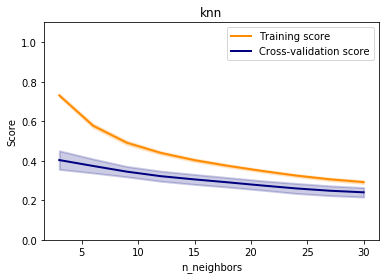

In [156]:
n_range = range(3,33,3)
plot_validation_curve(KNeighborsRegressor(), 'knn', 
                      x, y, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=RepeatedKFold(n_splits=5, n_repeats=5), scoring="r2")